# Image Normalization

[Normalization](https://en.wikipedia.org/wiki/Normalization_(image_processing)) is commonly used for preprocessing biological images. During normalization, the range of pixel intensity values is changed.  Therefore, it is crucial for differing pixel intensities between images to ensure comparability and quantification of biological features across different images.

However, while normalization can enhance consistency and detectability of patterns, it can also lead to distortion, i.e. suppression or exaggeration of signals, if it is not carefully applied. Finding the balance between noise reduction and risk of losing biological variability is crucial for successfully analyzing images.

This notebook is meant to demonstrate possible impacts and risks of normalization that need to be considered.

In [28]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from stackview import insight

For demonstrating how normalization works, we will use `blobs.tif` as an example image.

In [29]:
image = imread('../../data/blobs.tif')

Now we can use `stackview.insight` to display the image and essential properties of the image:

StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
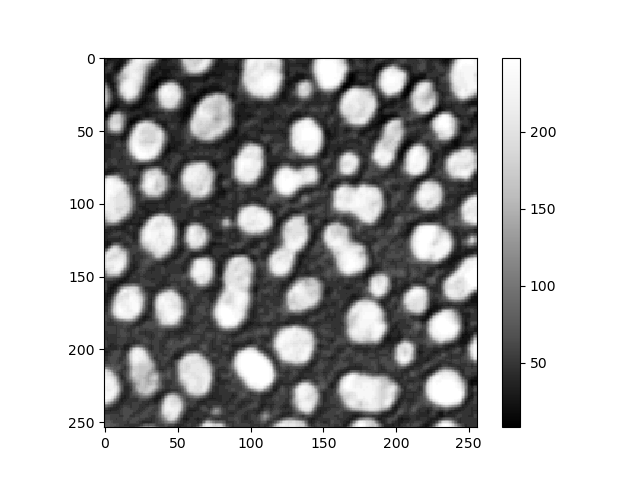
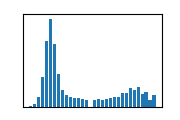

In [30]:

insight(image)

We can see that our image is of datatype unsigned 8-bit integer, short uint8. This means:
- __unsigned__: the values are always positive
- __8-bit__: we can have 2^8 = 256 different intensity levels ranging from 0 to 255. 
- __integer__: the values are whole numbers

We can also see how these intensity levels are distributed in the intensity histogram. Lets try out different ways to normalize this image:

## Min-Max Normalization

One of the most common ways to normalize data is [min-max normalization](https://en.wikipedia.org/wiki/Feature_scaling#Methods). Let us try it out:

In [31]:
min_int = image.min()
max_int = image.max()
min_max = (image - min_int) / (max_int - min_int)

StackViewNDArray([[0.13333333, 0.1       , 0.06666667, ..., 0.86666667,
                   0.8       , 0.8       ],
                  [0.2       , 0.13333333, 0.06666667, ..., 0.93333333,
                   0.86666667, 0.86666667],
                  [0.23333333, 0.16666667, 0.06666667, ..., 0.96666667,
                   0.93333333, 0.93333333],
                  ...,
                  [0.26666667, 0.3       , 0.3       , ..., 0.16666667,
                   0.16666667, 0.16666667],
                  [0.3       , 0.3       , 0.3       , ..., 0.16666667,
                   0.16666667, 0.16666667],
                  [0.36666667, 0.33333333, 0.3       , ..., 0.16666667,
                   0.16666667, 0.16666667]])
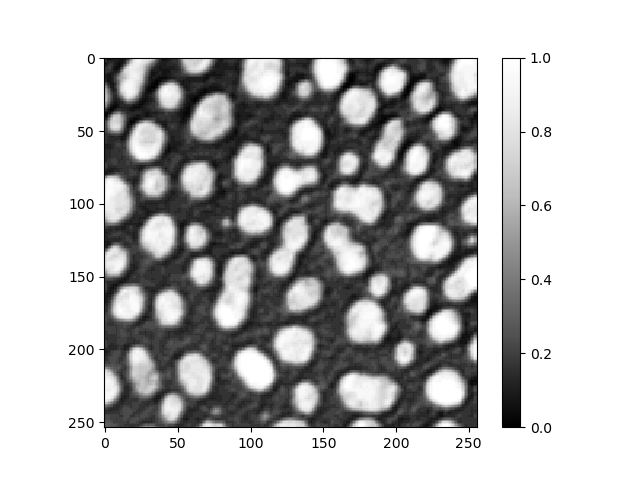
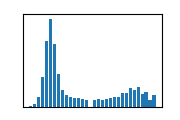

In [32]:
insight(min_max)

Min-max normalization leads to the transformation of the minimum intensity value of the image into a 0 and the maximum intensity value gets transformed into a 1. Every value in between gets transformed into a decimal between 0 and 1. 

We need to be able to represent decimal values and not whole numbers. Therefore, we cannot use a dtype of `uint8` anymore but need the floating point representation, here `float64`.

Let us compare the intensity histograms of our original and the min-max-normalized image:

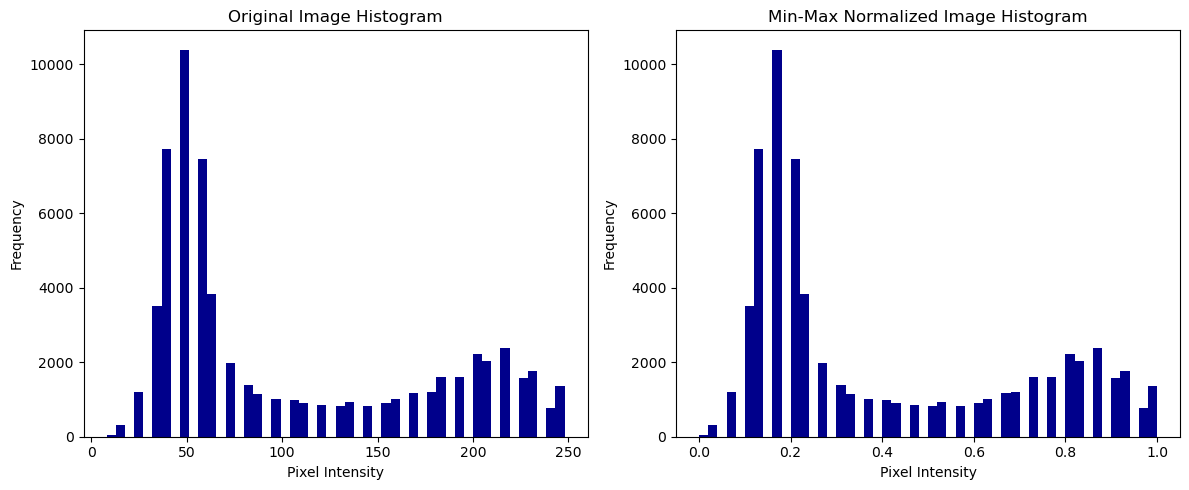

In [33]:
# Plot the histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create two subplots side by side

# Original image histogram
axes[0].hist(image.ravel(), bins=50, color='darkblue')
axes[0].set_title('Original Image Histogram')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

# Min-max normalized image histogram
axes[1].hist(min_max.ravel(), bins=50, color='darkblue')
axes[1].set_title('Min-Max Normalized Image Histogram')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

We can see that the two histograms look very similar and the min-max normalization ensures that pixel values are scaled to a common range, here 0 to 1. This is particularly useful when working with different datasets that need to be compared or used, for example for a machine learning algorithm. 

But we need to keep in mind that min-max normalization can be highly sensitive to outliers. Let us try to introduce such an outlier to investigate its impact on the min-max normalization. We first set a square in the original image to an intensity value of 0:

StackViewNDArray([[  0,   0,   0, ..., 216, 200, 200],
                  [  0,   0,   0, ..., 232, 216, 216],
                  [  0,   0,   0, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
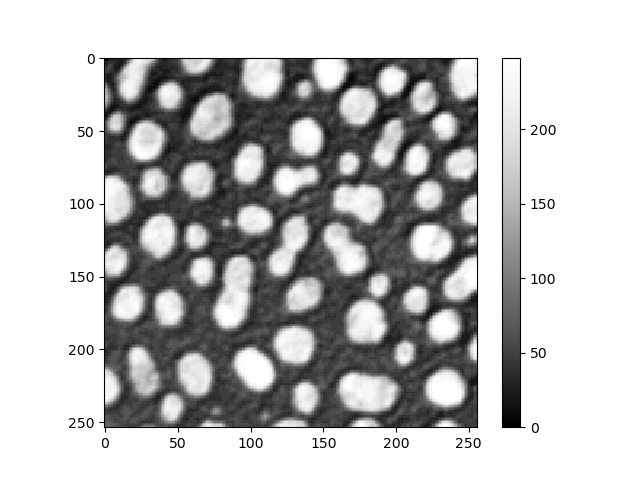
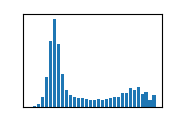

In [60]:
outlier_image = image.copy()

# Introduce a square outlier in the upper left corner (for example, 3x3 square)
outlier_image[0:25, 0:25] = 0  # Setting high intensity values in a 3x3 square
insight(outlier_image)

In [61]:
min_int_outlier = outlier_image.min()
max_int_outlier = outlier_image.max()
min_max_outlier = (outlier_image - min_int_outlier) / (max_int_outlier - min_int_outlier)

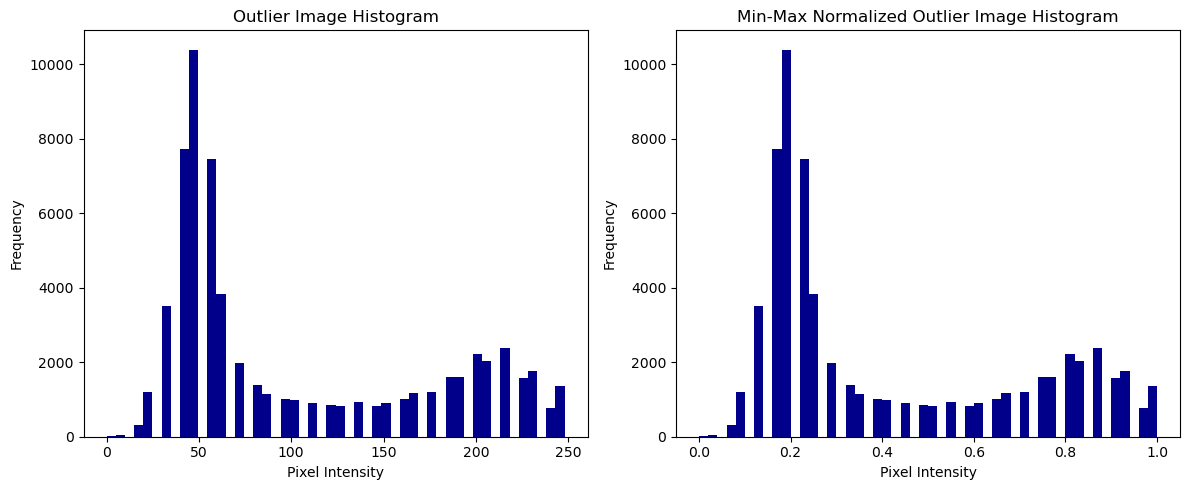

In [62]:
# Plot the histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create two subplots side by side

# Original image histogram
axes[0].hist(outlier_image.ravel(), bins=50, color='darkblue')
axes[0].set_title('Outlier Image Histogram')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

# Min-max normalized image histogram
axes[1].hist(min_max_outlier.ravel(), bins=50, color='darkblue')
axes[1].set_title('Min-Max Normalized Outlier Image Histogram')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

If an image contains very bright or, like in our case, dark pixels (e.g. due to noise or artifacts), these extreme values stretch the normalization range, causing most of the pixel values to be squeezed into a narrow range. A way to circumvent this behavior is to use Percentile-based Normalization.

## Percentile-based Normalization

StackViewNDArray([[0.        , 0.        , 0.        , ..., 0.87096774,
                   0.80645161, 0.80645161],
                  [0.        , 0.        , 0.        , ..., 0.93548387,
                   0.87096774, 0.87096774],
                  [0.        , 0.        , 0.        , ..., 0.96774194,
                   0.93548387, 0.93548387],
                  ...,
                  [0.29032258, 0.32258065, 0.32258065, ..., 0.19354839,
                   0.19354839, 0.19354839],
                  [0.32258065, 0.32258065, 0.32258065, ..., 0.19354839,
                   0.19354839, 0.19354839],
                  [0.38709677, 0.35483871, 0.32258065, ..., 0.19354839,
                   0.19354839, 0.19354839]])
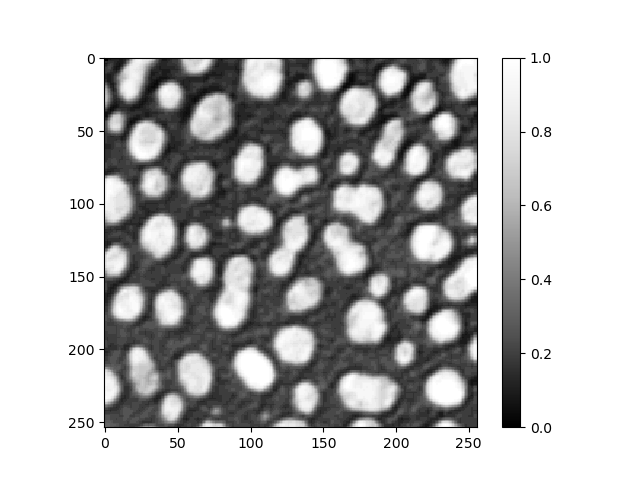
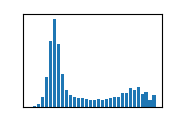

In [63]:
percentile_image = outlier_image/np.percentile(outlier_image,99)
insight(percentile_image)

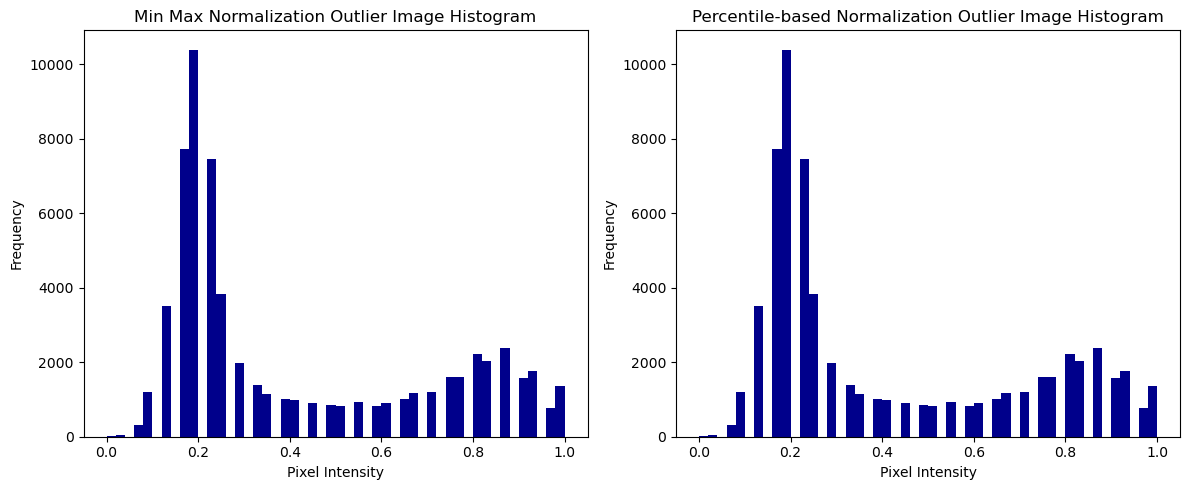

In [64]:
# Plot the histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create two subplots side by side

# Original image histogram
axes[0].hist(min_max_outlier.ravel(), bins=50, color='darkblue')
axes[0].set_title('Min Max Normalization Outlier Image Histogram')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

# Min-max normalized image histogram
axes[1].hist(percentile_image.ravel(), bins=50, color='darkblue')
axes[1].set_title('Percentile-based Normalization Outlier Image Histogram')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()